In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Dataset
The dataset includes American Sign Language Alphabet grayscale 28x28 images. The dataset can be found in [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist) also. The kaggle version includes a csv files which has 785 colums, 784 being pixels of the image and the last one being the label. The dataset does not include letters J and Z, since those letters require a movement to show.<br />
The dataset below extracted and usable for PyTorch <em>ImageFolder</em> function. 

In [2]:
!git clone https://github.com/metsey99/MNIST-Sign-Language-Dataset.git

Cloning into 'MNIST-Sign-Language-Dataset'...
remote: Enumerating objects: 34703, done.
remote: Total 34703 (delta 0), reused 0 (delta 0), pack-reused 34703
Receiving objects: 100% (34703/34703), 54.66 MiB | 50.69 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
data_dir = 'MNIST-Sign-Language-Dataset/train/'
data_dir_test = 'MNIST-Sign-Language-Dataset/test/'

BATCH_SIZE = 64
TRAIN_VAL_SPLIT = 0.8
FIRST_LAYER_DIM = 256
LEARNING_RATE = 1e-3
NUM_EPOCHS = 150

In [4]:
## Initializing the transformations(augmentations) that we will be applying
## to our images. I decided to use Random Horizontal Flip, and normalize them.
## Other transforms can be added too.
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = datasets.ImageFolder(data_dir, transform = transform)
dataset_test = datasets.ImageFolder(data_dir_test, transform = transform)

#splitting train and validation dataset with ratio 80-20 percent
train_data, val_data = torch.utils.data.random_split(dataset_train, 
                                      [int(len(dataset_train)*TRAIN_VAL_SPLIT), 
                    int(len(dataset_train)-len(dataset_train)*TRAIN_VAL_SPLIT)])

#converting the train, validation and test datasets into an iterable object
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=8)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             num_workers=8)

test_dataloader = torch.utils.data.DataLoader(dataset_test, num_workers=8)

classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y')

## Initializing the model

In [5]:
## A simple 4-layered Neural Network, extra linear and convolutional layers can
## be added. 
class BasicNN(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(BasicNN, self).__init__()
    self.fc1 = nn.Linear(in_dim, FIRST_LAYER_DIM)
    self.fc2 = nn.Linear(FIRST_LAYER_DIM, FIRST_LAYER_DIM//2)
    self.fc3 = nn.Linear(FIRST_LAYER_DIM//2, FIRST_LAYER_DIM//4)
    self.fc4 = nn.Linear(FIRST_LAYER_DIM//4, out_dim)
    self.act = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    ## Converting 3-channel images to grayscale, and flatten them.
    x = torch.mean(x, axis=1).reshape(x.shape[0], -1) # CxHxW (64x3x28x28) -> (64x28x28) -> (64, 784)

    x = self.act(self.fc1(x)) # (64, 256)
    x = self.act(self.fc2(x)) # (64, 128)
    x = self.act(self.fc3(x)) # (64, 64)
    x = self.act(self.fc4(x)) # (64, 25)
    x = self.softmax(x)
    return x

model = BasicNN(784, 25)

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BasicNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=25, bias=True)
  (act): ReLU()
  (softmax): Softmax(dim=None)
)

## Training the model

In [7]:
model.to(device)
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, NUM_EPOCHS+1):
    
  train_loss = 0.0
  train_acc = 0.0
  model.train()

  for batches, (images, labels) in enumerate(train_dataloader): # (x, 64, 3, 28, 28)
      
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(images) # (64, 25)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    top_k, top_c = output.topk(1, dim=1)
    equal = top_c == labels.view(*top_c.shape)
    train_acc += torch.mean(equal.type(torch.FloatTensor))

  test_loss = 0
  accuracy = 0
  model.eval()
  
  with torch.no_grad():
    for images, labels in val_dataloader:
      images, labels = images.to(device), labels.to(device)

      ps = model(images)

      test_loss += criterion(ps, labels)

      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(train_loss/len(train_dataloader))
    test_losses.append(test_loss/len(val_dataloader))
    train_accs.append(train_acc/len(train_dataloader))
    test_accs.append(accuracy/len(val_dataloader))


  print("Epoch: {}/{}\n".format(epoch, NUM_EPOCHS),
            "Training Loss: {:.3f}\n".format(train_loss/len(train_dataloader)),
            "Training Accuracy: {:.5f}\n".format(train_acc/len(train_dataloader)),
            "Test Loss: {:.3f}\n".format(test_loss/len(val_dataloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(val_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/150
 Training Loss: 3.014
 Training Accuracy: 0.27857
 Test Loss: 2.932
 Test Accuracy: 0.356
Epoch: 2/150
 Training Loss: 2.866
 Training Accuracy: 0.42147
 Test Loss: 2.851
 Test Accuracy: 0.435
Epoch: 3/150
 Training Loss: 2.830
 Training Accuracy: 0.45562
 Test Loss: 2.826
 Test Accuracy: 0.459
Epoch: 4/150
 Training Loss: 2.812
 Training Accuracy: 0.47406
 Test Loss: 2.808
 Test Accuracy: 0.481
Epoch: 5/150
 Training Loss: 2.786
 Training Accuracy: 0.49994
 Test Loss: 2.758
 Test Accuracy: 0.530
Epoch: 6/150
 Training Loss: 2.741
 Training Accuracy: 0.54568
 Test Loss: 2.712
 Test Accuracy: 0.580
Epoch: 7/150
 Training Loss: 2.674
 Training Accuracy: 0.61390
 Test Loss: 2.650
 Test Accuracy: 0.635
Epoch: 8/150
 Training Loss: 2.653
 Training Accuracy: 0.63257
 Test Loss: 2.643
 Test Accuracy: 0.641
Epoch: 9/150
 Training Loss: 2.630
 Training Accuracy: 0.65689
 Test Loss: 2.611
 Test Accuracy: 0.676
Epoch: 10/150
 Training Loss: 2.610
 Training Accuracy: 0.67527
 Test Los

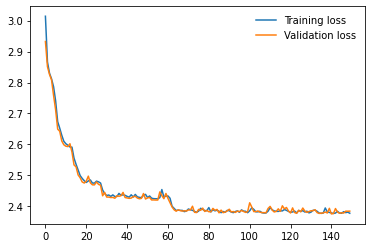

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig("BasicNet_Loss.png")

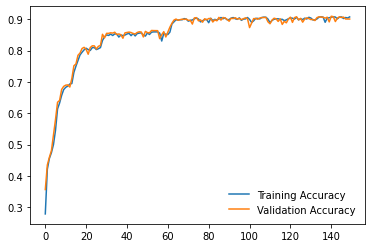

In [9]:
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.legend(frameon=False)
plt.savefig("BasicNet_Accuracy.png")

## Testing the Model

In [15]:
correct = 0
total = 0
model.to(device)
test_dataloader_size = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_dataloader_size +=1
print('Accuracy of the network on the %d test images: %d %%' % (test_dataloader_size,
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 7172 test images: 67 %
